In [719]:
import json 
import os
import logging 
import concurrent 
import asyncio 
import requests 

from itertools import chain 
from datetime import date, datetime 

from typing import List 
from pprint import PrettyPrinter
from subgrounds import Subgrounds
from subgrounds.pagination import ShallowStrategy
from IPython.display import HTML, display
from web3 import Web3
from functools import partial 
from concurrent.futures import ThreadPoolExecutor
from gql import gql, Client
from gql.transport.aiohttp import AIOHTTPTransport

import pandas as pd 
import numpy as np 
import altair as alt 
import missingno as miss

# logging.basicConfig(level=logging.INFO)

# TODO: Figure out how this frax subgraph is useful
# https://api.thegraph.com/subgraphs/name/frax-finance-data/fraxbp-subgraph/graphql

pp = PrettyPrinter().pprint

In [720]:
URL_INFURA = 'https://mainnet.infura.io/v3/856c3834f317452a82e25bb06e04de18'
w3 = Web3(Web3.HTTPProvider(URL_INFURA))

### Bribes Analysis 

We are interested in analyzing the impact of bribes through 

- Votium (voting power vlCVX, incentives in FXS) 
- Pitch 
- bribe.crv.finance 
- Hidden Hand 
- Aura 

that incentivize liquidity in liquidity pools that contain FRAX. To start, we are working with the following subset of pools that exist on curve. 
- Metapools (stable / non-stable). 
- Frax BP
- Frax:3crv

The following metrics are of interest

- \\$ Bribes spent per pool (broken down by platform and incentive type)  
- \\$ Liquidity per pool (broken into Frax and non-Frax components) 

Once we have both the liquidity and bribe information, we can try to answer these questions
- Where are bribe dollars best spent? 
- How does the Frax protocol optimize its bribing strategy in order to maximize the amount of liquidity within it's pools? 

In [721]:
def ddf(df):
    display(HTML(df.to_html()))
    
    
def remove_prefix(df: pd.DataFrame, prefix: str):
    # Remove a prefix from all columns 
    cols = [c for c in df.columns]
    for i, c in enumerate(cols): 
        if c.startswith(prefix): 
            cols[i] = c[len(prefix):]
    df.columns = cols 
    return df 

def remove_prefixes(df: pd.DataFrame, prefixes: List[str]):
    for p in prefixes: 
        df = remove_prefix(df, p)
    return df 

def zip_dfs(dfs, col_names): 
    data = dfs[0]
    for i, c in enumerate(col_names): 
        data = data.merge(dfs[i+1][[c]], how='left', left_index=True, right_index=True)
    return data

def query_attrs(query, attrs):
    return sg.query_df([getattr(query, a) for a in attrs], pagination_strategy=ShallowStrategy) 


async def graphql_execute(
    query, 
    variable_values=None, 
    paginate=False, 
    page_size=10000, 
    page_size_variable='page_size', 
    page_offset_variable='page_offset',
    verbose=False, 
):
    variable_values = variable_values or {}
    transport = AIOHTTPTransport(url=URL_SNAPSHOT)
    # Using `async with` on the client will start a connection on the transport
    # and provide a `session` variable to execute queries on this connection
    async with Client(transport=transport, fetch_schema_from_transport=True) as session:
        if not paginate:
            gquery = gql(query)
            result = await session.execute(gquery)
            if verbose: 
                logging.info(f"Query returned {len(result)} records with page size {page_size}.")
            return result 
        else: 
            results = []
            finished = False 
            i = 0 
            while not finished:
                gquery = gql(query)
                # Could be a failure point but works for single queries 
                query_name = gquery.to_dict()['definitions'][0]['name']['value'].lower()
                query_resp = await session.execute(
                    gquery, variable_values={
                        **variable_values, page_offset_variable: page_size * i, page_size_variable: page_size
                    }
                )
                result = query_resp[query_name]
                if verbose: 
                    logging.info(f"Paginated query returned {len(result)} records with page size {page_size}.")
                finished = len(result) == 0
                results.append(result)
                i += 1
            return list(chain(*results)) 

In [799]:
# Non-subgraph
URL_SNAPSHOT = 'https://hub.snapshot.org/graphql'
# Subgraph 
URL_VOTIUM = 'https://api.thegraph.com/subgraphs/name/convex-community/votium-bribes' 
URL_CURVE_POOLS = 'https://api.thegraph.com/subgraphs/name/convex-community/curve-pools'
URL_CURVE_VOL_MAINNET = 'https://api.thegraph.com/subgraphs/name/convex-community/volume-mainnet' 

# Addresses 
VOTIUM_VOTER = '0xde1E6A7ED0ad3F61D531a8a78E83CcDdbd6E0c49'.lower()
CURVE_POOL_FRAX_USDC = '0xdcef968d416a41cdac0ed8702fac8128a64241a2'
ADDRESS_FXS = '0x3432B6A60D23Ca0dFCa7761B7ab56459D9C964D0'.lower()
ADDRESS_CRVFRAX = '0x3175df0976dfa876431c2e9ee6bc45b65d3473cc'.lower()

In [800]:
# Instantiate the client with an endpoint.
sg = Subgrounds()

# votium_bribes = sg.load_subgraph(URL_VOTIUM) 
sg_curve_pools = sg.load_subgraph(URL_CURVE_POOLS) 
sg_curve_vol = sg.load_subgraph(URL_CURVE_VOL_MAINNET)
sg_votium = sg.load_subgraph(URL_VOTIUM) 

### Metapool TVL  

In [803]:
# Discovery of all curve metapools that have gauges 
# We will later get all pools paired with the fraxBP, and join in this extra gauge data for the relevant pools. 
query_metapools = sg_curve_pools.Query.pools(
    first=100, where={'coins_contains': [ADDRESS_CRVFRAX]}
)
attrs = [
    'id',
    'name',
    'gauge',
    'token', # convex receipt token. TODO: How does this work? 
    'lpToken', 
    'swap', # pool contract address 
    'coins',
    'assetType', 
]
df_metapools_gauges = sg.query_df(
    [getattr(query_metapools, a) for a in attrs], pagination_strategy=ShallowStrategy
) 
df_metapools_gauges.pools_assetType = df_metapools_gauges.pools_assetType.apply(lambda v: {0: "USD", 4: "CRYPTO"}[int(v)])
print(len(df_metapools_gauges))
df_metapools_gauges.head()

36


pools_id                                   pools_name  \
0      101    Curve.fi Factory USD Metapool: sUSDFRAXBP   
1      101    Curve.fi Factory USD Metapool: sUSDFRAXBP   
2      102    Curve.fi Factory USD Metapool: LUSDFRAXBP   
3      102    Curve.fi Factory USD Metapool: LUSDFRAXBP   
4      103  Curve.fi Factory USD Metapool: apeUSDFRAXBP   

                                  pools_gauge  \
0  0xf6d7087d4ae4dcf85956d743406e63cda74d99ad   
1  0xf6d7087d4ae4dcf85956d743406e63cda74d99ad   
2  0x389fc079a15354e9cbce8258433cc0f85b755a42   
3  0x389fc079a15354e9cbce8258433cc0f85b755a42   
4  0xd6e48cc0597a1ee12a8beeb88e22bfdb81777164   

                                  pools_token  \
0  0x8e2a6e9390cbd4c3895d07e4cb171c0527990df6   
1  0x8e2a6e9390cbd4c3895d07e4cb171c0527990df6   
2  0xe8a371b5d32344033589a2f0a2712dbd12130b18   
3  0xe8a371b5d32344033589a2f0a2712dbd12130b18   
4  0x5ec62bad0fa0c6b7f87b3b86edfe1bcd2a3139e2   

                                pools_lpToken  \
0  0xe3c190c57b5959ae62efe3b6797058b76ba2f5ef   
1  0xe3c190c57b5959ae62efe3b6797058b76ba2f5ef   
2  0x497ce58f34605b9944e6b15ecafe6b001206fd25   
3  0x497ce58f34605b9944e6b15ecafe6b001206fd25   
4  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   

                                   pools_swap  \
0  0xe3c190c57b5959ae62efe3b6797058b76ba2f5ef   
1  0xe3c190c57b5959ae62efe3b6797058b76ba2f5ef   
2  0x497ce58f34605b9944e6b15ecafe6b001206fd25   
3  0x497ce58f34605b9944e6b15ecafe6b001206fd25   
4  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   

                                  pools_coins pools_assetType  
0  0x57ab1ec28d129707052df4df418d58a2d46d5f51             USD  
1  0x3175df0976dfa876431c2e9ee6bc45b65d3473cc             USD  
2  0x5f98805a4e8be255a32880fdec7f6728c6568ba0             USD  
3  0x3175df0976dfa876431c2e9ee6bc45b65d3473cc             USD  
4  0xff709449528b6fb6b88f557f7d93dece33bca78d             USD

In [809]:
# query pool data 
query_pools = sg_curve_vol.Query.pools(first=100, where={'coins_contains': [ADDRESS_CRVFRAX]})
dfs_pools = query_attrs(query_pools, ['id', 'name', 'lpToken', 'symbol', 'coins', 'coinNames', 'coinDecimals', 'poolType'])
# process pool data
df_pools = zip_dfs(dfs_pools, ['pools_coinNames', 'pools_coinDecimals'])
df_pools = df_pools.reset_index() 
df_pools['coin_index'] = (
    # There's one row in this df for each combination of a pool and a coin. So a pool with 3 coins will lead to 3 rows. 
    # When subgrounds flattens data in producing output dataframes, the order of the rows is preserved so this method 
    # is fine for determining the coin index (assuming we didn't do any sorting after pulling the data. 
    df_pools.groupby('pools_id', sort=False)['index'].rank(method='first').astype(int)
)
df_pools = df_pools.drop(columns=['index'])
df_pools = df_pools.rename(columns={'pools_id': 'pool_address'})

# TODO: Some pools have the same symbol and multiple addresses. Remove older ones based on creation date or active status. Look at this for metapools 
# TODO: Figure out how to compute coin_index more efficiently (inner group rank). Probably a groupwise cumulative count. Use this same method 
#       for the above todo. 

print(len(df_pools.pool_address.unique()))

df_pools.head()

46


pool_address  \
0  0x02dfa5c793a9ce4d767a86259245a162a57f2db4   
1  0x02dfa5c793a9ce4d767a86259245a162a57f2db4   
2  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
3  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
4  0x0aace9b6c491d5cd9f80665a2fcc1af09e9ccf00   

                                     pools_name  \
0  Curve.fi Factory Crypto Pool: bentCVX/FraxBP   
1  Curve.fi Factory Crypto Pool: bentCVX/FraxBP   
2   Curve.fi Factory USD Metapool: apeUSDFRAXBP   
3   Curve.fi Factory USD Metapool: apeUSDFRAXBP   
4      Curve.fi Factory USD Metapool: handleUSD   

                                pools_lpToken    pools_symbol  \
0  0xbb23c0361d3e436fb7942a0e103edecab3afa917    bentCVXFRX-f   
1  0xbb23c0361d3e436fb7942a0e103edecab3afa917    bentCVXFRX-f   
2  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d  APEUSDBP3CRV-f   
3  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d  APEUSDBP3CRV-f   
4  0x0aace9b6c491d5cd9f80665a2fcc1af09e9ccf00     fxUSD3CRV-f   

                                  pools_coins  pools_poolType pools_coinNames  \
0  0x9e0441e084f5db0606565737158aa6ab6b970fe0  CRYPTO_FACTORY         bentCVX   
1  0x3175df0976dfa876431c2e9ee6bc45b65d3473cc  CRYPTO_FACTORY         crvFRAX   
2  0xff709449528b6fb6b88f557f7d93dece33bca78d  STABLE_FACTORY          ApeUSD   
3  0x3175df0976dfa876431c2e9ee6bc45b65d3473cc  STABLE_FACTORY         crvFRAX   
4  0x8616e8ea83f048ab9a5ec513c9412dd2993bce3f  STABLE_FACTORY           fxUSD   

   pools_coinDecimals  coin_index  
0                  18           1  
1                  18           2  
2                  18           1  
3                  18           2  
4                  18           1

In [793]:
pool_ids

['0xe3c190c57b5959ae62efe3b6797058b76ba2f5ef',
 '0x497ce58f34605b9944e6b15ecafe6b001206fd25',
 '0x04b727c7e246ca70d496ecf52e6b6280f3c8077d',
 '0x4e43151b78b5fbb16298c1161fcbf7531d5f8d93',
 '0x8fdb0bb9365a46b145db80d0b1c5c5e979c84190',
 '0xb30da2376f63de30b42dc055c93fa474f31330a5',
 '0x4606326b4db89373f5377c316d3b0f6e55bc6a20',
 '0x33baeda08b8afacc4d3d07cf31d49fc1f1f3e893',
 '0xc47ebd6c0f68fd5963005d28d0ba533750e5c11b',
 '0xe57180685e3348589e9521aa53af0bcd497e884d',
 '0x58257e4291f95165184b4bea7793a1d6f8e7b627',
 '0xbec570d92afb7ffc553bdd9d4b4638121000b10d',
 '0x31c325a01861c7dbd331a9270296a31296d797a0',
 '0x21d158d95c2e150e144c36fc64e3653b8d6c6267',
 '0x4149d1038575ce235e03e03b39487a80fd709d31',
 '0x66e335622ad7a6c9c72c98dbfcce684996a20ef9',
 '0x13b876c26ad6d21cb87ae459eaf6d7a1b788a113',
 '0x6a6283ab6e31c2aec3fa08697a8f806b740660b2']

In [792]:
query_pools = sg_curve_vol.Query.pools(first=50, where={"id": "0x326290a1b0004eee78fa6ed4f1d8f4b2523ab669"})
dfs_pools = query_attrs(query_pools, ['id', 'name', 'lpToken', 'symbol', 'coins', 'coinNames', 'coinDecimals'])
dfs_pools

[                                     pools_id  \
 0  0x326290a1b0004eee78fa6ed4f1d8f4b2523ab669   
 1  0x326290a1b0004eee78fa6ed4f1d8f4b2523ab669   
 
                                   pools_name  \
 0  Curve.fi Factory USD Metapool: XAI/FRAXBP   
 1  Curve.fi Factory USD Metapool: XAI/FRAXBP   
 
                                 pools_lpToken     pools_symbol  \
 0  0x326290a1b0004eee78fa6ed4f1d8f4b2523ab669  XAIFRAXBP3CRV-f   
 1  0x326290a1b0004eee78fa6ed4f1d8f4b2523ab669  XAIFRAXBP3CRV-f   
 
                                   pools_coins  
 0  0xd7c9f0e536dc865ae858b0c0453fe76d13c3beac  
 1  0x3175df0976dfa876431c2e9ee6bc45b65d3473cc  ,
                                      pools_id  \
 0  0x326290a1b0004eee78fa6ed4f1d8f4b2523ab669   
 1  0x326290a1b0004eee78fa6ed4f1d8f4b2523ab669   
 
                                   pools_name  \
 0  Curve.fi Factory USD Metapool: XAI/FRAXBP   
 1  Curve.fi Factory USD Metapool: XAI/FRAXBP   
 
                                 pools_lpToken 

In [617]:
# The name, type, and address of some of the largest curve metapools 
# curve_metapools = [
#     ('agEUR+FRAXBP', 'CRYPTO V2', '0x58257e4291f95165184b4bea7793a1d6f8e7b627'),
#     ('ALCX+FRAXBP', 'CRYPTO V2', '0x4149d1038575ce235e03e03b39487a80fd709d31'),
#     ('alUSD+FRAXBP', 'USD', '0xB30dA2376F63De30b42dC055C93fa474F31330A5'),
#     ('ApeUSD+FRAXBP', 'USD', '0x04b727C7e246CA70d496ecF52E6b6280f3c8077D'),
#     ('BADGER+FRAXBP', 'CRYPTO V2', '0x13b876c26ad6d21cb87ae459eaf6d7a1b788a113'),
#     ('BENT+FRAXBP', 'CRYPTO V2', '0x825722af244432319c1e32b6b18aded2d4a014df'),
#     ('BUSD+FRAXBP', 'USD', '0x8fdb0bB9365a46B145Db80D0B1C5C5e979C84190'),
#     ('CVX+FRAXBP', 'CRYPTO V2', '0xbec570d92afb7ffc553bdd9d4b4638121000b10d'),
#     ('cvxCRV+FRAXBP', 'CRYPTO V2', '0x31c325a01861c7dbd331a9270296a31296d797a0'),
#     ('cvxFXS+FRAXBP', 'CRYPTO V2', '0x21d158d95c2e150e144c36fc64e3653b8d6c6267'),
#     ('DOLA+FRAXBP', 'USD', '0xE57180685E3348589E9521aa53Af0BCD497E884d'),
#     ('GUSD+FRAXBP', 'USD', '0x4e43151b78b5fbb16298C1161fcbF7531d5F8D93'),
#     ('LUSD+FRAXBP', 'USD', '0x497CE58F34605B9944E6b15EcafE6b001206fd25'),
#     ('MAI+FRAXBP', 'USD', '0x66E335622ad7a6C9c72c98dbfCCE684996a20Ef9'),
#     ('pUSD+FRAXBP', 'USD', '0xC47EBd6c0f68fD5963005D28D0ba533750E5C11B'),
#     ('RSR+FRAXBP', 'CRYPTO V2', '0x6a6283ab6e31c2aec3fa08697a8f806b740660b2'),
#     ('SDT+FRAXBP', 'CRYPTO V2', '0x3e3c6c7db23cddef80b694679aaf1bcd9517d0ae'),
#     ('sUSD+FRAXBP', 'USD', '0xe3c190c57b5959Ae62EfE3B6797058B76bA2f5eF'),
#     ('TUSD+FRAXBP', 'USD', '0x33baeDa08b8afACc4d3d07cf31d49FC1F1f3E893'),
#     ('USDD+FRAXBP', 'USD', '0x4606326b4Db89373F5377C316d3b0F6e55Bc6A20'),
#     ('XAI+FRAXBP', 'USD', '0x326290a1b0004eee78fa6ed4f1d8f4b2523ab669'),
# ] 
# pool_addresses = [e[2] for e in curve_metapools] 
# pool_address_type_map = {e[2].lower(): e[1] for e in curve_metapools}


def get_curve_metapools():
    """Queries the curve volume subgraph `Pools` entity to get metadata for all curve metapools 
    """
    pool_ids = list(set(pool_addresses + [e.lower() for e in pool_addresses])) # normalize for lower case 
    
    # query pool data 
    query_pools = sg_curve_vol.Query.pools(first=50, where={"id_in": pool_ids})
    dfs_pools = query_attrs(query_pools, ['id', 'name', 'lpToken', 'symbol', 'coins', 'coinNames', 'coinDecimals'])
    
    # process pool data
    df_pools = zip_dfs(dfs_pools, ['pools_coinNames', 'pools_coinDecimals'])
    df_pools = df_pools.reset_index() 
    df_pools['coin_index'] = (
        # There's one row in this df for each combination of a pool and a coin. So a pool with 3 coins will lead to 3 rows. 
        # When subgrounds flattens data in producing output dataframes, the order of the rows is preserved so this method 
        # is fine for determining the coin index (assuming we didn't do any sorting after pulling the data. 
        df_pools.groupby('pools_id', sort=False)['index'].rank(method='first').astype(int)
    )
    df_pools['pool_type'] = df_pools.pools_id.apply(lambda a: pool_address_type_map[a.lower()])
    df_pools = df_pools.drop(columns=['index'])
    assert len(curve_metapools) == len(df_pools.pools_symbol.unique()) 
    df_pools = df_pools.rename(columns={'pools_id': 'pool_address'})
    
    return df_pools

    
def get_curve_pool_reserves(pool_ids, verbose=True): 
    """Queries the curve volume subgraph `DailyPoolSnapshots` entity to get daily snapshots of metrics 
    for each curve metapool in our analysis. 
    """
    nrows = -1
    nreturned = 1000
    while nrows == -1 or nrows == nreturned:
        nreturned *= 10
        query_pool_snaps = sg_curve_vol.Query.dailyPoolSnapshots(where={"pool_in": pool_ids}, first=nreturned)
        df_reserves = query_attrs(query_pool_snaps, ['id', 'timestamp', 'reservesUSD']).reset_index()
        nrows = len(df_reserves)

    # Process pool snapshots 
    df_reserves['timestamp'] = pd.to_datetime(df_reserves.dailyPoolSnapshots_timestamp, unit='s')
    df_reserves['pool_address'] = df_reserves.dailyPoolSnapshots_id.apply(lambda _id: _id.split('-')[0])
    df_reserves['coin_index'] = (
        df_reserves.groupby(['dailyPoolSnapshots_id', 'dailyPoolSnapshots_timestamp'], sort=False)['index'].rank(method='first').astype(int)
    )
    df_reserves = df_reserves.drop(columns=['index'])
    return df_reserves

In [618]:
df_pools = get_curve_metapools()

In [619]:
df_pools.head()

pool_address  \
0  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
1  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
2  0x13b876c26ad6d21cb87ae459eaf6d7a1b788a113   
3  0x13b876c26ad6d21cb87ae459eaf6d7a1b788a113   
4  0x21d158d95c2e150e144c36fc64e3653b8d6c6267   

                                    pools_name  \
0  Curve.fi Factory USD Metapool: apeUSDFRAXBP   
1  Curve.fi Factory USD Metapool: apeUSDFRAXBP   
2  Curve.fi Factory Crypto Pool: BADGER/FRAXBP   
3  Curve.fi Factory Crypto Pool: BADGER/FRAXBP   
4  Curve.fi Factory Crypto Pool: cvxFxs/FraxBP   

                                pools_lpToken    pools_symbol  \
0  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d  APEUSDBP3CRV-f   
1  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d  APEUSDBP3CRV-f   
2  0x09b2e090531228d1b8e3d948c73b990cb6e60720    BADGERFRAX-f   
3  0x09b2e090531228d1b8e3d948c73b990cb6e60720    BADGERFRAX-f   
4  0xf57ccad8122b898a147cc8601b1eca88b1662c7e    cvxFxsFrax-f   

                                  pools_coins pools_coinNames  \
0  0xff709449528b6fb6b88f557f7d93dece33bca78d          ApeUSD   
1  0x3175df0976dfa876431c2e9ee6bc45b65d3473cc         crvFRAX   
2  0x3472a5a71965499acd81997a54bba8d852c6e53d          BADGER   
3  0x3175df0976dfa876431c2e9ee6bc45b65d3473cc         crvFRAX   
4  0xfeef77d3f69374f66429c91d732a244f074bdf74          cvxFXS   

   pools_coinDecimals  coin_index  pool_type  
0                  18           1        USD  
1                  18           2        USD  
2                  18           1  CRYPTO V2  
3                  18           2  CRYPTO V2  
4                  18           1  CRYPTO V2

In [620]:
pool_ids = df_pools.pool_address.unique().tolist()
df_reserves = get_curve_pool_reserves(pool_ids)

In [621]:
df_reserves.head()

dailyPoolSnapshots_id  \
0  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d-165...   
1  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d-165...   
2  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d-165...   
3  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d-165...   
4  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d-165...   

   dailyPoolSnapshots_timestamp  dailyPoolSnapshots_reservesUSD  timestamp  \
0                    1656547200                        0.000000 2022-06-30   
1                    1656547200                        0.000000 2022-06-30   
2                    1656633600                        0.000000 2022-07-01   
3                    1656633600                        0.000000 2022-07-01   
4                    1656720000                    66782.220309 2022-07-02   

                                 pool_address  coin_index  
0  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d           1  
1  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d           2  
2  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d           1  
3  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d           2  
4  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d           1

In [782]:
len(df_reserves.pool_address.unique())

21

In [622]:
df_liquidity = df_reserves.merge(
    df_pools, how='left', on=['pool_address', 'coin_index'], validate="m:1" 
)

In [623]:
# df_liquidity.loc[df_liquidity.pools_symbol == 'BADGERFRAX-f'].tail()

### Metapool TVL Charts 

#### TVL Faceted by Metapool Segmented by Coin Name 

In [624]:
(
    alt.Chart(df_liquidity)
    .mark_area()
    .transform_calculate(stack_order="datum.pools_coinNames === 'crvFRAX' ? 0 : 1")
    .encode(
        x="dailyPoolSnapshots_timestamp:T", 
        y="dailyPoolSnapshots_reservesUSD:Q", 
        color=alt.Color("pools_coinNames:N", scale=alt.Scale(scheme="tableau20")), 
        tooltip=alt.Tooltip("dailyPoolSnapshots_reservesUSD:Q", format='$,d'), 
        facet=alt.Facet('pools_symbol:N', columns=3),
        order="stack_order:O", 
    )
    .resolve_scale(y="independent")
)

/opt/miniconda3/envs/frax-bribes/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

#### Current Metapool Liquidity Faceted by Asset Type Segmented by Metapool

In [625]:
df_tvl = (
    df_liquidity[df_liquidity.pools_coinNames != 'crvFRAX']
    .groupby("pools_name", sort="timestamp").last().reset_index()
    [['dailyPoolSnapshots_reservesUSD', 'pool_type', 'pools_coinNames']]
)
df_tvl = df_tvl.merge(
    df_tvl.groupby('pool_type')['dailyPoolSnapshots_reservesUSD'].sum().reset_index().rename(columns={'dailyPoolSnapshots_reservesUSD': 'tvl_total'}), 
    how='left', on="pool_type", validate="m:1"
)
df_tvl['tvl_share'] = df_tvl.dailyPoolSnapshots_reservesUSD / df_tvl.tvl_total
# df_tvl.head()

In [626]:
(
    alt.Chart(df_tvl)
    .mark_arc()
    .encode(
        theta="dailyPoolSnapshots_reservesUSD:Q", 
        color=alt.Color("pools_coinNames:N", scale=alt.Scale(scheme="tableau20")), 
        facet=alt.Facet('pool_type:N', columns=3),
        tooltip=[
            alt.Tooltip("pools_coinNames:N", title="Token"), 
            alt.Tooltip("dailyPoolSnapshots_reservesUSD:Q", format="$,d", title="TVL"),
            alt.Tooltip("tvl_share:Q", format=".1%", title="TVL Share")
        ] 
    )
    .resolve_scale(theta="independent")
)

/opt/miniconda3/envs/frax-bribes/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

#### Current Metapool Liquidity Segmented By Asset Type 

In [627]:
df_tvl_type = df_liquidity.copy()
df_tvl_type.dailyPoolSnapshots_reservesUSD = df_tvl_type.dailyPoolSnapshots_reservesUSD.astype(np.float64)
df_tvl_type = (
    df_tvl_type[df_tvl_type.pools_coinNames != 'crvFRAX']
    .groupby(["pool_type", "timestamp"], dropna=False)['dailyPoolSnapshots_reservesUSD'].sum().reset_index()
    .rename(columns={'dailyPoolSnapshots_reservesUSD': 'tvl_type'})
)
df_tvl_total = df_tvl_type.groupby("timestamp")['tvl_type'].sum().reset_index().rename(columns={'tvl_type': 'tvl_total'})

In [628]:
df_tvl_type.sort_values(['timestamp', 'pool_type']).tail()

pool_type  timestamp      tvl_type
225        USD 2022-11-20  4.536477e+07
80   CRYPTO V2 2022-11-21  1.269732e+07
226        USD 2022-11-21  4.554431e+07
81   CRYPTO V2 2022-11-22  1.127672e+07
227        USD 2022-11-22  4.391666e+07

In [629]:
df_tvl_total.tail()

timestamp     tvl_total
141 2022-11-18  5.815059e+07
142 2022-11-19  5.758985e+07
143 2022-11-20  5.851614e+07
144 2022-11-21  5.824163e+07
145 2022-11-22  5.519338e+07

In [630]:
(
    alt.Chart(df_tvl_type)
    .mark_area()
    .encode(
        x="timestamp:T", 
        y="tvl_type:Q", 
        color="pool_type:N", 
        tooltip=["pool_type:N", alt.Tooltip("tvl_type:Q", format="$,d")]
    ) + 
    alt.Chart(df_tvl_total)
    .mark_line(color="green")
    .encode(
        x="timestamp:T", 
        y="tvl_total:Q", 
        tooltip=[alt.Tooltip("tvl_total:Q", format="$,d")]
    )
)

/opt/miniconda3/envs/frax-bribes/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.LayerChart(...)

### Snapshot Proposals 

Here, we get the snapshot proposals that correspond to votium votes. Each proposal contains the possible set of choices (liquidity pools that rewards can be directed to). 

In [631]:
async def get_snapshot_proposals(): 
    """Get all snapshot proposals corresponding to convex gauge weight votes. 
    
    Within each gauge weight vote, holders of vlCVX collectively determine how convex should distribute it's 
    veCRV in subsequent curve gauge votes. 
    
    - Votes are pulled from the snapshot graphql endpoint. 
    """
    proposal_attrs = ['id', 'title', 'choices', 'start', 'end', 'state']
    proposals = await graphql_execute(
        """query Proposals {
          proposals(
            first: 10000,
            where: {
              space: "cvx.eth"         
              # id: "0xee37337fd2b8b5112ac4efd2948d58e4e44f59ee904c70650d26ece60276ed9f"
            },
            orderBy: "created",
            orderDirection: desc
          ) {
            <proposal_attrs>
          }
        }
        """.replace('<proposal_attrs>', '\n'.join(proposal_attrs))
    )
    proposals = proposals['proposals']
    # Number of rounds here should match number of rounds on llama airforce 
    # https://llama.airforce/#/bribes/rounds/votium/cvx-crv/
    df_proposals = pd.DataFrame([
        d for d in proposals 
        if d['title'].startswith('Gauge Weight for Week') and d['state'] == 'closed' # TODO: Should we consider active proposals in some way? 
    ])
    df_proposals.start = pd.to_datetime(df_proposals.start, unit='s').dt.date
    df_proposals.end = pd.to_datetime(df_proposals.end, unit='s').dt.date 
    df_proposals = df_proposals.sort_values('start').reset_index(drop=True)
    # On votium, the proposal id is keccak256 hashed. So we need to perform this operation on the data pulled from snapshot 
    df_proposals['id_keccak256'] = df_proposals.id.apply(
        lambda _id: Web3.keccak(text=_id).hex() if not _id.startswith('0x') else Web3.keccak(hexstr=_id).hex()
    )
    # Validate that this query pulls in all data by ensuring that the number of votium voting rounds we get from this query 
    # matches the expected number of voting rounds, which we can compute using simple timedelta logic, the date of the 
    # first vote, and the current date. 
    dmin = pd.Timestamp('2021-09-16') # day of the first votium snapshot 
    assert pd.Timestamp(df_proposals.start.min()) == dmin
    df_proposals['start_diff'] = df_proposals.start.shift(1) - df_proposals.start
    assert (df_proposals.iloc[1:,].start_diff == pd.Timedelta('-14 days')).all()
    # Since a proposal happens every two weeks, and we know the date of the first proposal, we can compute the number of expected proposals on any given date. 
    num_proposals_expected = (
        int(np.ceil((pd.Timestamp(pd.Timestamp.now().date()) - dmin) / pd.Timedelta("14 days")))
    )
    df_proposals['proposal_id'] = df_proposals.id 
    df_proposals = df_proposals.rename(columns={
        'title': 'proposal_title', 
        'choices': 'vote_choices', 
        'start': 'proposal_start', 
        'end': 'proposal_end', 
        'id_keccak256': 'proposal_id_keccak256'
    })
    df_proposals = df_proposals.sort_values('proposal_start').reset_index(drop=True).reset_index()
    df_proposals['proposal_round'] = df_proposals['index'] + 1 
    df_proposals = df_proposals.drop(columns=['index', 'start_diff', 'id', 'state']) 
    assert len(df_proposals) == num_proposals_expected
    return df_proposals 
    
    
async def get_snapshot_votes(proposal_ids, verbose=True): 
    """Get all votes for all convex gauge weight snapshot proposals. 
        
    - Votes are pulled from the snapshot graphql endpoint. 
    """
    votes = await graphql_execute(
        '''
            query Votes($page_size: Int!, $page_offset: Int!, $proposal_ids: [String]!) {
              votes (
                first: $page_size
                skip: $page_offset
                where: { proposal_in: $proposal_ids }
              ) {
                proposal { id }
                id
                voter
                created
                choice
                vp
                vp_by_strategy
                vp_state
              }
            }
        ''', 
        paginate=True, 
        variable_values={'proposal_ids': proposal_ids}
    )
    vote_records = []
    for v in votes: 
        for index, amount in v['choice'].items(): 
            # TODO: data validation step / what does vp_state on this entity mean? Sometimes it's pending but still seems to be counted in votes. 
            # assert v['vp_state'] == 'final'
            r = {
                **v, 
                'choice_index': int(index) - 1, 
                'amount': amount, 
                'is_votium': v['voter'].lower() == VOTIUM_VOTER
            }
            del r['choice'] 
            vote_records.append(r)
    df_votes = pd.DataFrame(vote_records)
    df_votes['proposal_id'] = df_votes.proposal.apply(lambda v: v['id']) 
    df_votes['vote_id'] = df_votes['id'] 
    # Different voters represent their choice amount in different ways. So we group by each unique combination of voter and proposal and normalize on a per vote level. 
    df_votes['proposal_voter_amount_total'] = df_votes.groupby(['proposal_id', 'voter'])['amount'].transform('sum')
    df_votes['choice_percent'] = df_votes.amount / df_votes.proposal_voter_amount_total * 100
    df_votes = df_votes.drop(columns=['proposal', 'id', 'vp_by_strategy', 'vp_state', 'proposal_voter_amount_total']) 
    df_votes = df_votes.rename(columns={'created': 'vote_created', 'vp': 'vote_power'})
    return df_votes

In [632]:
df_proposals = await get_snapshot_proposals()

In [633]:
print(f"Number of votium snapshot proposals: {len(df_proposals)}")
df_proposals.head()

Number of votium snapshot proposals: 31


proposal_title  \
0  Gauge Weight for Week of 16th Sep 2021   
1  Gauge Weight for Week of 30th Sep 2021   
2  Gauge Weight for Week of 14th Oct 2021   
3  Gauge Weight for Week of 28th Oct 2021   
4  Gauge Weight for Week of 11th Nov 2021   

                                        vote_choices proposal_start  \
0  [compound, usdt, ypool, busd, susd, pax, ren, ...     2021-09-16   
1  [compound, usdt, ypool, busd, susd, pax, ren, ...     2021-09-30   
2  [compound, usdt, ypool, busd, susd, pax, ren, ...     2021-10-14   
3  [compound, usdt, ypool, busd, susd, pax, ren, ...     2021-10-28   
4  [compound, usdt, ypool, busd, susd, pax, ren, ...     2021-11-11   

  proposal_end                              proposal_id_keccak256  \
0   2021-09-21  0xc841db892a58168d21262eb8e2f97d651fb354896fa9...   
1   2021-10-05  0xe11de27c199ddee0966ed8b24e1ee34bd3363f0fe09f...   
2   2021-10-19  0x20b26be17c62c2d155f9f9a9a3dac7bc3fcaa4845322...   
3   2021-11-02  0xb439c625f9f4929f6b486f79d5ae6850971d179a0887...   
4   2021-11-16  0x77cebe9bd4bc9836f115774c7387839e77abe3dda613...   

                                      proposal_id  proposal_round  
0  QmUjELF3ABSV2f5xgQrJgEnZTPb86DAtT6gzoa8RfHUuAK               1  
1  QmTQBqsG7dW93xX8zBZnevMa1mbEmDHUx7QabAYyn6mFJi               2  
2  QmaS9vd1vJKQNBYX4KWQ3nppsTT3QSL3nkz5ZYSwEJk6hZ               3  
3  QmacSRTG62rnvAyBuNY3cVbCtBHGV8PuGRoL32Dm6MPy5y               4  
4  QmPSBg5aTPb82sZRqF9ouUQQ5CkbpRaJMdHYUMieN3dpqv               5

In [634]:
df_choices = df_proposals.explode('vote_choices').reset_index().rename(columns={'vote_choices': 'choice'})
df_choices['choice_index'] = df_choices.groupby('proposal_id').cumcount()
df_choices = df_choices[['choice', 'choice_index', 'proposal_round', 'proposal_title', 'proposal_id', 'proposal_id_keccak256']]
df_choices['choice'] = df_choices.choice.str.lower()
df_choices.tail()

choice  choice_index  proposal_round  \
3415          op-sbtc+wbtc (0x9f2f…)           150              31   
3416      op-dai+usdc+usdt (0x1337…)           151              31   
3417          op-frax+usdc (0x29a3…)           152              31   
3418  xdai-wxdai+usdc+usdt (0x7f90…)           153              31   
3419                  vefunder-vyper           154              31   

                              proposal_title  \
3415  Gauge Weight for Week of 10th Nov 2022   
3416  Gauge Weight for Week of 10th Nov 2022   
3417  Gauge Weight for Week of 10th Nov 2022   
3418  Gauge Weight for Week of 10th Nov 2022   
3419  Gauge Weight for Week of 10th Nov 2022   

                                            proposal_id  \
3415  0xd7db40d1ca142cb5ca24bce5d0f78f3b037fde6c7ebb...   
3416  0xd7db40d1ca142cb5ca24bce5d0f78f3b037fde6c7ebb...   
3417  0xd7db40d1ca142cb5ca24bce5d0f78f3b037fde6c7ebb...   
3418  0xd7db40d1ca142cb5ca24bce5d0f78f3b037fde6c7ebb...   
3419  0xd7db40d1ca142cb5ca24bce5d0f78f3b037fde6c7ebb...   

                                  proposal_id_keccak256  
3415  0xc7e65a46a6fa9a085ff994c30ba19c95cbaf8ee64c49...  
3416  0xc7e65a46a6fa9a085ff994c30ba19c95cbaf8ee64c49...  
3417  0xc7e65a46a6fa9a085ff994c30ba19c95cbaf8ee64c49...  
3418  0xc7e65a46a6fa9a085ff994c30ba19c95cbaf8ee64c49...  
3419  0xc7e65a46a6fa9a085ff994c30ba19c95cbaf8ee64c49...

In [635]:
gauge_data = requests.get('https://api.curve.fi/api/getAllGauges').json()
df_gauges = pd.DataFrame([
    {
        'gauge_name': d['name'].lower(), 
        'gauge_short_name': d['shortName'].lower(), 
        'gauge_address': d['swap_token']
    } 
    for _, d in data['data'].items() 
])
df_gauges.head()

gauge_name           gauge_short_name  \
0    ibbtc+sbtccrv (0x99ae…bf27)    ibbtc+sbtccrv (0x99ae…)   
1       ausdc+adai (0x6a27…1dca)       ausdc+adai (0x6a27…)   
2  sdvecrv-dao+crv (0x737b…097b)  sdvecrv-dao+crv (0x737b…)   
3    btcpx+sbtccrv (0x4e52…2530)    btcpx+sbtccrv (0x4e52…)   
4        pwrd+3crv (0x2de8…e1a5)        pwrd+3crv (0x2de8…)   

                                gauge_address  
0  0x99ae07e7ab61dcce4383a86d14f61c68cdccbf27  
1  0x6a274de3e2462c7614702474d64d376729831dca  
2  0x737bc004136f66ae3f8fd5a1199e81c18388097b  
3  0x4e52cfc80679f402d10f7766fa3f85351a7c2530  
4  0x2de8c952871317fb9f22c73bb66bf86a1eebe1a5

In [636]:
proposal_ids = [e.lower() for e in df_proposals.proposal_id.unique().tolist()]
df_votes = await get_snapshot_votes(proposal_ids)

In [637]:
df_votes.head()

voter  vote_created    vote_power  \
0  0xde1E6A7ED0ad3F61D531a8a78E83CcDdbd6E0c49    1668470405  1.643775e+07   
1  0xde1E6A7ED0ad3F61D531a8a78E83CcDdbd6E0c49    1668470405  1.643775e+07   
2  0xde1E6A7ED0ad3F61D531a8a78E83CcDdbd6E0c49    1668470405  1.643775e+07   
3  0xde1E6A7ED0ad3F61D531a8a78E83CcDdbd6E0c49    1668470405  1.643775e+07   
4  0xde1E6A7ED0ad3F61D531a8a78E83CcDdbd6E0c49    1668470405  1.643775e+07   

   choice_index amount  is_votium  \
0            28    322       True   
1            30   1125       True   
2            33    424       True   
3            38   2279       True   
4            45    540       True   

                                         proposal_id  \
0  0xd7db40d1ca142cb5ca24bce5d0f78f3b037fde6c7ebb...   
1  0xd7db40d1ca142cb5ca24bce5d0f78f3b037fde6c7ebb...   
2  0xd7db40d1ca142cb5ca24bce5d0f78f3b037fde6c7ebb...   
3  0xd7db40d1ca142cb5ca24bce5d0f78f3b037fde6c7ebb...   
4  0xd7db40d1ca142cb5ca24bce5d0f78f3b037fde6c7ebb...   

                                             vote_id choice_percent  
0  0xf5201fe8b4bd6f8305fa0969f100e54fed078664d054...           3.22  
1  0xf5201fe8b4bd6f8305fa0969f100e54fed078664d054...          11.25  
2  0xf5201fe8b4bd6f8305fa0969f100e54fed078664d054...           4.24  
3  0xf5201fe8b4bd6f8305fa0969f100e54fed078664d054...          22.79  
4  0xf5201fe8b4bd6f8305fa0969f100e54fed078664d054...            5.4

In [638]:
df_snaps = df_votes.merge(df_proposals, how='left', on='proposal_id', validate='m:1')

def row_mapper(row): 
    row['vote_choice'] = row['vote_choices'][int(row['choice_index'])]
    return row 

df_snaps = df_snaps.apply(row_mapper, axis=1)
df_snaps['vote_power_allocated'] = (df_snaps.choice_percent / 100) * df_snaps.vote_power 
df_snaps = df_snaps[[
    'proposal_round', 'proposal_title', 'proposal_start', 'proposal_end', 'voter', 'vote_power', 
    'vote_created', 'vote_choice', 'choice_percent', 'choice_index', 
    'vote_power_allocated', 
    'proposal_id', 'vote_id', 'proposal_id_keccak256'
]]
df_snaps = df_snaps.sort_values(['proposal_round', 'proposal_start']).reset_index(drop=True) 
# df_snaps.choice_index = df_snaps.choice_index.astype(int)

In [639]:
(
    alt.Chart((
        df_snaps[['proposal_round', 'vote_choice', 'vote_power_allocated']]
        .groupby(['proposal_round', 'vote_choice']).sum()
        .reset_index() 
    ))
    .mark_bar()
    .encode(
        x="proposal_round:O", 
        y="vote_power_allocated:Q", 
        color="vote_choice:N", 
        tooltip=["vote_choice:N", "vote_power_allocated:Q"]
    )
    .properties(width=500) 
)

/opt/miniconda3/envs/frax-bribes/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

### Votium Bribes 

In [640]:
df_snaps.head()

proposal_round                          proposal_title proposal_start  \
0               1  Gauge Weight for Week of 16th Sep 2021     2021-09-16   
1               1  Gauge Weight for Week of 16th Sep 2021     2021-09-16   
2               1  Gauge Weight for Week of 16th Sep 2021     2021-09-16   
3               1  Gauge Weight for Week of 16th Sep 2021     2021-09-16   
4               1  Gauge Weight for Week of 16th Sep 2021     2021-09-16   

  proposal_end                                       voter    vote_power  \
0   2021-09-21  0xde1E6A7ED0ad3F61D531a8a78E83CcDdbd6E0c49  2.171453e+06   
1   2021-09-21  0xde1E6A7ED0ad3F61D531a8a78E83CcDdbd6E0c49  2.171453e+06   
2   2021-09-21  0xde1E6A7ED0ad3F61D531a8a78E83CcDdbd6E0c49  2.171453e+06   
3   2021-09-21  0xde1E6A7ED0ad3F61D531a8a78E83CcDdbd6E0c49  2.171453e+06   
4   2021-09-21  0xde1E6A7ED0ad3F61D531a8a78E83CcDdbd6E0c49  2.171453e+06   

   vote_created vote_choice  choice_percent  choice_index  \
0    1632182562        eurs        8.720190            22   
1    1632182562     ankreth       10.245874            27   
2    1632182562        frax       63.664015            32   
3    1632182562       alusd       17.308531            36   
4    1632182562      cvxcrv        0.061390            41   

   vote_power_allocated                                     proposal_id  \
0          1.893549e+05  QmUjELF3ABSV2f5xgQrJgEnZTPb86DAtT6gzoa8RfHUuAK   
1          2.224844e+05  QmUjELF3ABSV2f5xgQrJgEnZTPb86DAtT6gzoa8RfHUuAK   
2          1.382434e+06  QmUjELF3ABSV2f5xgQrJgEnZTPb86DAtT6gzoa8RfHUuAK   
3          3.758467e+05  QmUjELF3ABSV2f5xgQrJgEnZTPb86DAtT6gzoa8RfHUuAK   
4          1.333058e+03  QmUjELF3ABSV2f5xgQrJgEnZTPb86DAtT6gzoa8RfHUuAK   

                                          vote_id  \
0  QmZ6KsSz71Q93VY9RXjbKXUPX36VBAhFJqe8wX6jJuEaBa   
1  QmZ6KsSz71Q93VY9RXjbKXUPX36VBAhFJqe8wX6jJuEaBa   
2  QmZ6KsSz71Q93VY9RXjbKXUPX36VBAhFJqe8wX6jJuEaBa   
3  QmZ6KsSz71Q93VY9RXjbKXUPX36VBAhFJqe8wX6jJuEaBa   
4  QmZ6KsSz71Q93VY9RXjbKXUPX36VBAhFJqe8wX6jJuEaBa   

                               proposal_id_keccak256  
0  0xc841db892a58168d21262eb8e2f97d651fb354896fa9...  
1  0xc841db892a58168d21262eb8e2f97d651fb354896fa9...  
2  0xc841db892a58168d21262eb8e2f97d651fb354896fa9...  
3  0xc841db892a58168d21262eb8e2f97d651fb354896fa9...  
4  0xc841db892a58168d21262eb8e2f97d651fb354896fa9...

In [641]:
# Get all votium voting epochs. Once we have validated that this set of epochs matches our set of snapshot proposals, 
# we need to merge this data with our snapshot proposal data. 
epoches = sg_votium.Query.epoches(first=1000, orderBy="initiatedAt", where={"bribeCount_gt": 0})
df_epoches = sg.query_df([epoches.id, epoches.initiatedAt], pagination_strategy=ShallowStrategy)
# df_epoches = remove_prefix(df_epoches, "epoches_")
df_epoches.epoches_initiatedAt = pd.to_datetime(df_epoches.epoches_initiatedAt, unit="s")
df_epoches['date'] = df_epoches.epoches_initiatedAt.dt.date
# Validate that the epoch dates for votium bribes match the proposal data we pulled from snapshot. `
epoch_dates = df_epoches.date.unique().tolist()
proposal_dates = df_snaps.proposal_start.unique().tolist()
d_exclude = pd.Timestamp('2021-11-08').date()
assert d_exclude in epoch_dates and not d_exclude in proposal_dates
epoch_dates.remove(d_exclude)
assert set(epoch_dates) == set(proposal_dates)
df_epoches = df_epoches.loc[df_epoches.date != d_exclude].reset_index(drop=True)
df_epoches = df_epoches.sort_values('date').reset_index().rename(columns={'index': 'round'})
df_epoches['round'] += 1
df_epoches.tail()

round                                         epoches_id  \
26     27  0x7348c424b991d683f8a8c4ff8ad54803b571fa23fb05...   
27     28  0x0f5d75e0b0b506ba9ff2c394d40ed7b105e9a3523d53...   
28     29  0xb9262aa45b24da69f1793438d6f43da0425d99ae2e72...   
29     30  0xf25f333d0eff881950706755ca73764e3875f76d5012...   
30     31  0xc7e65a46a6fa9a085ff994c30ba19c95cbaf8ee64c49...   

   epoches_initiatedAt        date  
26 2022-09-15 00:02:12  2022-09-15  
27 2022-09-29 00:00:59  2022-09-29  
28 2022-10-13 00:01:23  2022-10-13  
29 2022-10-27 00:03:11  2022-10-27  
30 2022-11-10 00:01:35  2022-11-10

In [642]:
# https://github.com/convex-community/convex-subgraph/blob/main/subgraphs/votium/src/mapping.ts

# Addresses associated with the frax protocol used for votium bribes 
# TODO: Frax controls some subset of the TVL in it's liquidity pools. Need to be cognizant of this because it leads 
#       to a rebate the lowers the cost of bribing. 
# TODO: Frax's vlCVX is not custodied in the investor custodian wallet. 
frax_bribe_addresses = [
    # ('comptroller', '0xb1748c79709f4ba2dd82834b8c82d4a505003f27'),
    # ('cvx locker amo', '0x7038c406e7e2c9f81571557190d26704bb39b8f3'),
    ('investor custodian', '0x5180db0237291A6449DdA9ed33aD90a38787621c'),
    ('frax1.eth', '0x234D953a9404Bf9DbC3b526271d440cD2870bCd2'),
]
# TODO: Check to see if there are bribes in FRAX 
bribes = sg_votium.Query.bribes(first=100000, where={
    "epoch_in": df_epoches.epoches_id.unique().tolist(), "token": ADDRESS_FXS
})
df_bribes = sg.query_df([bribes.id, bribes.amount, bribes.choiceIndex, bribes.epoch.id], pagination_strategy=ShallowStrategy)
df_bribes = remove_prefix(df_bribes, "bribes_")
df_bribes['tx_hash'] = df_bribes['id'].apply(lambda _id: _id.split('-')[0])
df_bribes.amount /= 1e18
df_bribes = df_bribes.drop(columns=['id'])
df_bribes = df_bribes.rename(columns={'amount': 'bribe_fxs', 'choiceIndex': 'choice_index'})
ddf(df_bribes.head())

In [643]:
# Determine the "from" address for the transaction that contained the bribe 
tx_hashes = df_bribes.tx_hash.unique()

def get_tx(tx_hash): 
    return w3.eth.get_transaction(tx_hash)['from'] 

tx_from_map = {}
with concurrent.futures.ThreadPoolExecutor(max_workers=10) as executor:
    futures = {tx_hash: executor.submit(get_tx, tx_hash) for tx_hash in tx_hashes}
    for tx_hash, future in futures.items(): 
        tx_from_map[tx_hash] = future.result()

In [644]:
df_bribes['from'] = df_bribes['tx_hash'].apply(lambda tx_hash: tx_from_map[tx_hash])
address_labels = {addr.lower(): name for name, addr in frax_bribe_addresses}
df_bribes['briber_label'] = df_bribes['from'].apply(lambda a: address_labels.get(a.lower()))
label_counts = df_bribes.briber_label.value_counts(dropna=False)
print("Label count for bribing address") 
print(label_counts)
print(f"Dropping {label_counts[None]} bribe(s)")
df_bribes = df_bribes.loc[~df_bribes.briber_label.isna()] 
df_bribes = df_bribes.drop(columns=['tx_hash', 'from']).sort_values(['briber_label', 'choice_index']).reset_index(drop=True)
df_bribes.head()

Label count for bribing address
investor custodian    137
frax1.eth              21
None                    1
Name: briber_label, dtype: int64
Dropping 1 bribe(s)


bribe_fxs  choice_index                                           epoch_id  \
0   31509.12            32  0xe11de27c199ddee0966ed8b24e1ee34bd3363f0fe09f...   
1   76922.88            32  0x20b26be17c62c2d155f9f9a9a3dac7bc3fcaa4845322...   
2   37280.64            32  0xc841db892a58168d21262eb8e2f97d651fb354896fa9...   
3  147040.32            33  0xc26deaa05f45f3f6ad088cb6603d77cb2e826ff98b69...   
4  219089.28            33  0xee224d8e52bc9240eef248d30fa4b1a525c0f686da23...   

  briber_label  
0    frax1.eth  
1    frax1.eth  
2    frax1.eth  
3    frax1.eth  
4    frax1.eth

In [645]:
# Match bribes with their corresponding round 
df_bribes_full = df_epoches.merge(df_bribes, how='right', left_on='epoches_id', right_on='epoch_id', validate='1:m') 
df_bribes_full.head()

round                                         epoches_id  \
0      2  0xe11de27c199ddee0966ed8b24e1ee34bd3363f0fe09f...   
1      3  0x20b26be17c62c2d155f9f9a9a3dac7bc3fcaa4845322...   
2      1  0xc841db892a58168d21262eb8e2f97d651fb354896fa9...   
3      7  0xc26deaa05f45f3f6ad088cb6603d77cb2e826ff98b69...   
4      8  0xee224d8e52bc9240eef248d30fa4b1a525c0f686da23...   

  epoches_initiatedAt        date  bribe_fxs  choice_index  \
0 2021-09-30 00:02:12  2021-09-30   31509.12            32   
1 2021-10-14 00:04:43  2021-10-14   76922.88            32   
2 2021-09-16 00:04:43  2021-09-16   37280.64            32   
3 2021-12-09 00:10:50  2021-12-09  147040.32            33   
4 2021-12-23 00:02:44  2021-12-23  219089.28            33   

                                            epoch_id briber_label  
0  0xe11de27c199ddee0966ed8b24e1ee34bd3363f0fe09f...    frax1.eth  
1  0x20b26be17c62c2d155f9f9a9a3dac7bc3fcaa4845322...    frax1.eth  
2  0xc841db892a58168d21262eb8e2f97d651fb354896fa9...    frax1.eth  
3  0xc26deaa05f45f3f6ad088cb6603d77cb2e826ff98b69...    frax1.eth  
4  0xee224d8e52bc9240eef248d30fa4b1a525c0f686da23...    frax1.eth

In [646]:
df_choices.head()

choice  choice_index  proposal_round  \
0  compound             0               1   
1      usdt             1               1   
2     ypool             2               1   
3      busd             3               1   
4      susd             4               1   

                           proposal_title  \
0  Gauge Weight for Week of 16th Sep 2021   
1  Gauge Weight for Week of 16th Sep 2021   
2  Gauge Weight for Week of 16th Sep 2021   
3  Gauge Weight for Week of 16th Sep 2021   
4  Gauge Weight for Week of 16th Sep 2021   

                                      proposal_id  \
0  QmUjELF3ABSV2f5xgQrJgEnZTPb86DAtT6gzoa8RfHUuAK   
1  QmUjELF3ABSV2f5xgQrJgEnZTPb86DAtT6gzoa8RfHUuAK   
2  QmUjELF3ABSV2f5xgQrJgEnZTPb86DAtT6gzoa8RfHUuAK   
3  QmUjELF3ABSV2f5xgQrJgEnZTPb86DAtT6gzoa8RfHUuAK   
4  QmUjELF3ABSV2f5xgQrJgEnZTPb86DAtT6gzoa8RfHUuAK   

                               proposal_id_keccak256  
0  0xc841db892a58168d21262eb8e2f97d651fb354896fa9...  
1  0xc841db892a58168d21262eb8e2f97d651fb354896fa9...  
2  0xc841db892a58168d21262eb8e2f97d651fb354896fa9...  
3  0xc841db892a58168d21262eb8e2f97d651fb354896fa9...  
4  0xc841db892a58168d21262eb8e2f97d651fb354896fa9...

In [647]:
df = (
    df_bribes_full.groupby(['round', 'choice_index'])['bribe_fxs'].sum()
    .reset_index()
    .merge(
        df_choices[['proposal_round', 'choice', 'choice_index']], 
        how='left',
        left_on=['round', 'choice_index'],
        right_on=['proposal_round', 'choice_index'], validate='m:1'
    )
    .merge(
        df_epoches[['round', 'epoches_initiatedAt']], 
        how='left', 
        on='round', 
        validate='m:1'
    )
    .drop(columns=['round'])
    .rename(columns={'epoches_initiatedAt': 'epoch_initiated_at'})
)
df['timestamp'] = pd.to_datetime(pd.to_datetime((df.epoch_initiated_at.astype(int) / 1e9).astype(int), unit='s').dt.date)
df.choice = df.choice.str.lower()
df.head()

choice_index  bribe_fxs  proposal_round choice  epoch_initiated_at  \
0            32   37280.64               1   frax 2021-09-16 00:04:43   
1            32   31509.12               2   frax 2021-09-30 00:02:12   
2            32   76922.88               3   frax 2021-10-14 00:04:43   
3            33   72288.96               4   frax 2021-10-28 11:02:59   
4            33  116033.28               5   frax 2021-11-11 00:04:34   

   timestamp  
0 2021-09-16  
1 2021-09-30  
2 2021-10-14  
3 2021-10-28  
4 2021-11-11

In [648]:
def process(df): 
    # Goal: For each choice in the snapshot proposal (i.e. a curve pool gauge), we want to pair the 
    #       choice name taken from the snapshot API with the address of the curve pool that choice 
    #       corresponds to. 
    
    # Remove irrelevant gauges  
    remove_choices = [
        "arbitrum-f-4pool", # 4pool never launched 
        "tusd", # Only bribed for in 1 round. Not really sure what to do about this one 
    ]
    df = df.loc[~df.choice.isin(remove_choices)]
    
    def preprocess_choice(choice):
        # Some older voting rounds used crvfrax while newer ones use fraxbp 
        choice = choice.replace('crvfrax', 'fraxbp')
        # Some older voting rounds prefixed factory pools with f- while newer rounds do not
        if choice.startswith("f-"): 
            choice = choice[2:]
        # Some older voting rounds showed addresses in form (0x...ab123)
        # whereas newer rounds use the form (0x...) without trailing values. 
        # Here, we remove trailing values if they exist 
        m = re.search('.*\\u2026([^\)]*)\)$', choice)
        if m: 
            choice = choice.replace(m.group(1), '') 
        return choice 
        
    df.choice = df.choice.apply(preprocess_choice)
    
    # We get the current set of gauges from the curve API. These names are what appear in the snapshot proposal 
    # This will get the most recent set of names but the structure of the names has changed over time. More work 
    # needs to be done to account for historical differences in naming pools 
    df = df.merge(df_gauges, how='left', left_on='choice', right_on='gauge_short_name')
    
    missed = df.loc[df.gauge_name.isna()].choice.unique()
 
    df_canonical_choices = pd.DataFrame(
        columns=['choice', 'canonical_choice'], 
        data=[
            ['frax', 'frax+usdc (0xdcef…)'], # fraxbp 
            ['d3pool', 'frax+fei+alusd (0xbaaa…)'], 
            ['fpifrax', 'frax+fpi (0xf861…)'], 
            ['2pool-frax', 'frax+usdc (0xdcef…)'], # fraxbp 
            ['fraxbpsusd', 'susd+fraxbp (0xe3c1…)'], 
            ['fraxbplusd', 'lusd+fraxbp (0x497c…)'], 
            ['fraxbpbusd', 'busd+fraxbp (0x8fdb…)'], 
            ['fraxbpape', 'apeusd+fraxbp (0x04b7…)'], 
            ['fraxbpalusd', 'alusd+fraxbp (0xb30d…)'], 
            ['fraxbpusdd', 'usdd+fraxbp (0x4606…)'], 
            ['fraxbptusd', 'tusd+fraxbp (0x33ba…)'], 
            ['fraxbpgusd', 'gusd+fraxbp (0x4e43…)'], 
        ]
    )    
    copy_cols = ['gauge_name', 'gauge_short_name', 'gauge_address']
    df = df.merge(df_canonical_choices, how='left', on='choice', validate='m:1')
    assert set(df.canonical_choice.dropna().unique()) == set(df_canonical_choices.canonical_choice.unique())
    df = pd.concat([
        # subset where we have already matched a choice to a gauge 
        df.loc[~df.gauge_name.isna()], 
        # subset where we have NOT matched a choice to a gauge 
        (
            df.loc[df.gauge_name.isna()]
            .drop(columns=df_gauges.columns.values.tolist()) 
            .merge(df_gauges, how='left', left_on='canonical_choice', right_on='gauge_short_name')
        )
    ])
    
    assert all(~df.gauge_address.isna()), "Unable to identify lp address for some choices"

    df = df.sort_values(['proposal_round', 'choice']).reset_index(drop=True)

    # miss.matrix(df)
    return df 

df = process(df) 

<>:22: DeprecationWarning: invalid escape sequence '\)'
<>:22: DeprecationWarning: invalid escape sequence '\)'
/var/folders/5c/hf9_blgj3jbbxxvkw_s9snsw0000gn/T/ipykernel_32348/1384607546.py:22: DeprecationWarning: invalid escape sequence '\)'
  m = re.search('.*\\u2026([^\)]*)\)$', choice)
/var/folders/5c/hf9_blgj3jbbxxvkw_s9snsw0000gn/T/ipykernel_32348/1384607546.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.choice = df.choice.apply(preprocess_choice)


In [649]:
# var = 'choice' 
var = 'gauge_short_name'
# var = 'gauge_address' 
(
    alt.Chart(df)
    .mark_bar()
    .encode(
        x="proposal_round:O", 
        y="bribe_fxs:Q", 
        color=f"{var}:N", 
        tooltip=[f'{var}:N', 'bribe_fxs:Q']
    )
)

/opt/miniconda3/envs/frax-bribes/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

In [650]:
df = df[['proposal_round', 'timestamp', 'gauge_short_name', 'bribe_fxs', 'gauge_address']] 
df.head()

# miss.matrix(df)

proposal_round  timestamp          gauge_short_name bribe_fxs  \
0               1 2021-09-16       frax+usdc (0xdcef…)  37280.64   
1               2 2021-09-30       frax+usdc (0xdcef…)  31509.12   
2               3 2021-10-14       frax+usdc (0xdcef…)  76922.88   
3               4 2021-10-28       frax+usdc (0xdcef…)  72288.96   
4               5 2021-11-11  frax+fei+alusd (0xbaaa…)   2368.32   

                                gauge_address  
0  0x3175df0976dfa876431c2e9ee6bc45b65d3473cc  
1  0x3175df0976dfa876431c2e9ee6bc45b65d3473cc  
2  0x3175df0976dfa876431c2e9ee6bc45b65d3473cc  
3  0x3175df0976dfa876431c2e9ee6bc45b65d3473cc  
4  0xbaaa1f5dba42c3389bdbc2c9d2de134f5cd0dc89

In [663]:
df_liquidity.dailyPoolSnapshots_timestamp = pd.to_datetime(df_liquidity.dailyPoolSnapshots_timestamp, unit='s')
df_liquidity = df_liquidity[
    ['dailyPoolSnapshots_timestamp', 'dailyPoolSnapshots_reservesUSD', 'pool_address', 'pools_name', 'pools_lpToken', 'pools_coins', 'pools_coinNames']
]
df_liquidity.head()

dailyPoolSnapshots_timestamp  dailyPoolSnapshots_reservesUSD  \
0                   2022-06-30                        0.000000   
1                   2022-06-30                        0.000000   
2                   2022-07-01                        0.000000   
3                   2022-07-01                        0.000000   
4                   2022-07-02                    66782.220309   

                                 pool_address  \
0  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
1  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
2  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
3  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
4  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   

                                    pools_name  \
0  Curve.fi Factory USD Metapool: apeUSDFRAXBP   
1  Curve.fi Factory USD Metapool: apeUSDFRAXBP   
2  Curve.fi Factory USD Metapool: apeUSDFRAXBP   
3  Curve.fi Factory USD Metapool: apeUSDFRAXBP   
4  Curve.fi Factory USD Metapool: apeUSDFRAXBP   

                                pools_lpToken  \
0  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
1  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
2  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
3  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
4  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   

                                  pools_coins pools_coinNames  
0  0xff709449528b6fb6b88f557f7d93dece33bca78d          ApeUSD  
1  0x3175df0976dfa876431c2e9ee6bc45b65d3473cc         crvFRAX  
2  0xff709449528b6fb6b88f557f7d93dece33bca78d          ApeUSD  
3  0x3175df0976dfa876431c2e9ee6bc45b65d3473cc         crvFRAX  
4  0xff709449528b6fb6b88f557f7d93dece33bca78d          ApeUSD

In [678]:
# Map each bribe to liquidty data point for it's corresponding pool 
dff_join = pd.merge_asof(
    df.sort_values('timestamp').reset_index(drop=True),
    df_liquidity.sort_values('dailyPoolSnapshots_timestamp').reset_index(drop=True),
    left_by=['gauge_address'], 
    right_by=['pool_address'], 
    left_on=['timestamp'], 
    right_on=['dailyPoolSnapshots_timestamp', ], 
)[['proposal_round', 'dailyPoolSnapshots_timestamp', 'gauge_short_name', 'bribe_fxs', 'gauge_address']]
dff_join = dff_join.loc[~dff_join.dailyPoolSnapshots_timestamp.isna()]
print(len(dff_join))
dff_join.head()

64


proposal_round dailyPoolSnapshots_timestamp       gauge_short_name  \
42              23                   2022-07-21  susd+fraxbp (0xe3c1…)   
43              23                   2022-07-21  lusd+fraxbp (0x497c…)   
44              23                   2022-07-21  busd+fraxbp (0x8fdb…)   
48              24                   2022-08-04  usdd+fraxbp (0x4606…)   
49              24                   2022-08-04  susd+fraxbp (0xe3c1…)   

   bribe_fxs                               gauge_address  
42    1473.6  0xe3c190c57b5959ae62efe3b6797058b76ba2f5ef  
43    281.28  0x497ce58f34605b9944e6b15ecafe6b001206fd25  
44    527.04  0x8fdb0bb9365a46b145db80d0b1c5c5e979c84190  
48    1344.0  0x4606326b4db89373f5377c316d3b0f6e55bc6a20  
49    1344.0  0xe3c190c57b5959ae62efe3b6797058b76ba2f5ef

In [679]:
df_liquidity.head()

dailyPoolSnapshots_timestamp  dailyPoolSnapshots_reservesUSD  \
0                   2022-06-30                        0.000000   
1                   2022-06-30                        0.000000   
2                   2022-07-01                        0.000000   
3                   2022-07-01                        0.000000   
4                   2022-07-02                    66782.220309   

                                 pool_address  \
0  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
1  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
2  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
3  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
4  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   

                                    pools_name  \
0  Curve.fi Factory USD Metapool: apeUSDFRAXBP   
1  Curve.fi Factory USD Metapool: apeUSDFRAXBP   
2  Curve.fi Factory USD Metapool: apeUSDFRAXBP   
3  Curve.fi Factory USD Metapool: apeUSDFRAXBP   
4  Curve.fi Factory USD Metapool: apeUSDFRAXBP   

                                pools_lpToken  \
0  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
1  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
2  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
3  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
4  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   

                                  pools_coins pools_coinNames  
0  0xff709449528b6fb6b88f557f7d93dece33bca78d          ApeUSD  
1  0x3175df0976dfa876431c2e9ee6bc45b65d3473cc         crvFRAX  
2  0xff709449528b6fb6b88f557f7d93dece33bca78d          ApeUSD  
3  0x3175df0976dfa876431c2e9ee6bc45b65d3473cc         crvFRAX  
4  0xff709449528b6fb6b88f557f7d93dece33bca78d          ApeUSD

In [680]:
dff_join.head()

proposal_round dailyPoolSnapshots_timestamp       gauge_short_name  \
42              23                   2022-07-21  susd+fraxbp (0xe3c1…)   
43              23                   2022-07-21  lusd+fraxbp (0x497c…)   
44              23                   2022-07-21  busd+fraxbp (0x8fdb…)   
48              24                   2022-08-04  usdd+fraxbp (0x4606…)   
49              24                   2022-08-04  susd+fraxbp (0xe3c1…)   

   bribe_fxs                               gauge_address  
42    1473.6  0xe3c190c57b5959ae62efe3b6797058b76ba2f5ef  
43    281.28  0x497ce58f34605b9944e6b15ecafe6b001206fd25  
44    527.04  0x8fdb0bb9365a46b145db80d0b1c5c5e979c84190  
48    1344.0  0x4606326b4db89373f5377c316d3b0f6e55bc6a20  
49    1344.0  0xe3c190c57b5959ae62efe3b6797058b76ba2f5ef

In [687]:
dff = (
    # 1. Ensure that the gauge information is attached to liquidity data 
    df_liquidity
    .merge(
        dff_join[['gauge_short_name', 'gauge_address']].drop_duplicates().reset_index(drop=True), 
        how='left', 
        left_on='pool_address', 
        right_on='gauge_address'
    ) 
    .merge(
        dff_join[['gauge_address', 'bribe_fxs', 'proposal_round', 'dailyPoolSnapshots_timestamp']], 
        how='left', 
        left_on=['pool_address', 'dailyPoolSnapshots_timestamp'], 
        right_on=['gauge_address', 'dailyPoolSnapshots_timestamp'], 
    ) 
    .drop(columns=['gauge_address_y'])
) 
dff = dff.loc[~dff.gauge_short_name.isna()]

# dff.bribe_fxs = dff.bribe_fxs.fillna(0)
# miss.matrix(dff) 
print(len(df_liquidity))
print(len(dff))

dff.head()

4158
2816


dailyPoolSnapshots_timestamp  dailyPoolSnapshots_reservesUSD  \
0                   2022-06-30                        0.000000   
1                   2022-06-30                        0.000000   
2                   2022-07-01                        0.000000   
3                   2022-07-01                        0.000000   
4                   2022-07-02                    66782.220309   

                                 pool_address  \
0  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
1  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
2  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
3  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
4  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   

                                    pools_name  \
0  Curve.fi Factory USD Metapool: apeUSDFRAXBP   
1  Curve.fi Factory USD Metapool: apeUSDFRAXBP   
2  Curve.fi Factory USD Metapool: apeUSDFRAXBP   
3  Curve.fi Factory USD Metapool: apeUSDFRAXBP   
4  Curve.fi Factory USD Metapool: apeUSDFRAXBP   

                                pools_lpToken  \
0  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
1  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
2  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
3  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
4  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   

                                  pools_coins pools_coinNames  \
0  0xff709449528b6fb6b88f557f7d93dece33bca78d          ApeUSD   
1  0x3175df0976dfa876431c2e9ee6bc45b65d3473cc         crvFRAX   
2  0xff709449528b6fb6b88f557f7d93dece33bca78d          ApeUSD   
3  0x3175df0976dfa876431c2e9ee6bc45b65d3473cc         crvFRAX   
4  0xff709449528b6fb6b88f557f7d93dece33bca78d          ApeUSD   

          gauge_short_name                             gauge_address_x  \
0  apeusd+fraxbp (0x04b7…)  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
1  apeusd+fraxbp (0x04b7…)  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
2  apeusd+fraxbp (0x04b7…)  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
3  apeusd+fraxbp (0x04b7…)  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
4  apeusd+fraxbp (0x04b7…)  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   

  bribe_fxs  proposal_round  
0       NaN             NaN  
1       NaN             NaN  
2       NaN             NaN  
3       NaN             NaN  
4       NaN             NaN

In [688]:
# base = (
#     alt.Chart(dff)
#     .transform_calculate(stack_order="datum.pools_coinNames === 'crvFRAX' ? 0 : 1")
#     .encode(
        
#         color=alt.Color("pools_coinNames:N", scale=alt.Scale(scheme="tableau20")), 
#         tooltip=alt.Tooltip("dailyPoolSnapshots_reservesUSD:Q", format='$,d'), 
#         facet=alt.Facet('pools_symbol:N', columns=3),
#         order="stack_order:O", 
#     )
#     .resolve_scale(y="independent")
# )
# liquidity = (
#     base
#     .mark_area()
#     .encode(
#         x="dailyPoolSnapshots_timestamp:T", 
#         y="dailyPoolSnapshots_reservesUSD:Q"
#     )
#     # .resolve_scale(y="independent")
# )
# bribes = (
#     base
#     .mark_bar()
#     .encode(
#         x="dailyPoolSnapshots_timestamp:T", 
#         y="bribe_fxs:Q",
#     )
#     .resolve_scale(y="independent")
# )

# # miss.matrix(dff)

# liquidity | bribes 

/opt/miniconda3/envs/frax-bribes/lib/python3.10/site-packages/missingno/missingno.py:73: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax0.grid(b=False)
/opt/miniconda3/envs/frax-bribes/lib/python3.10/site-packages/missingno/missingno.py:142: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=False)


<AxesSubplot: >

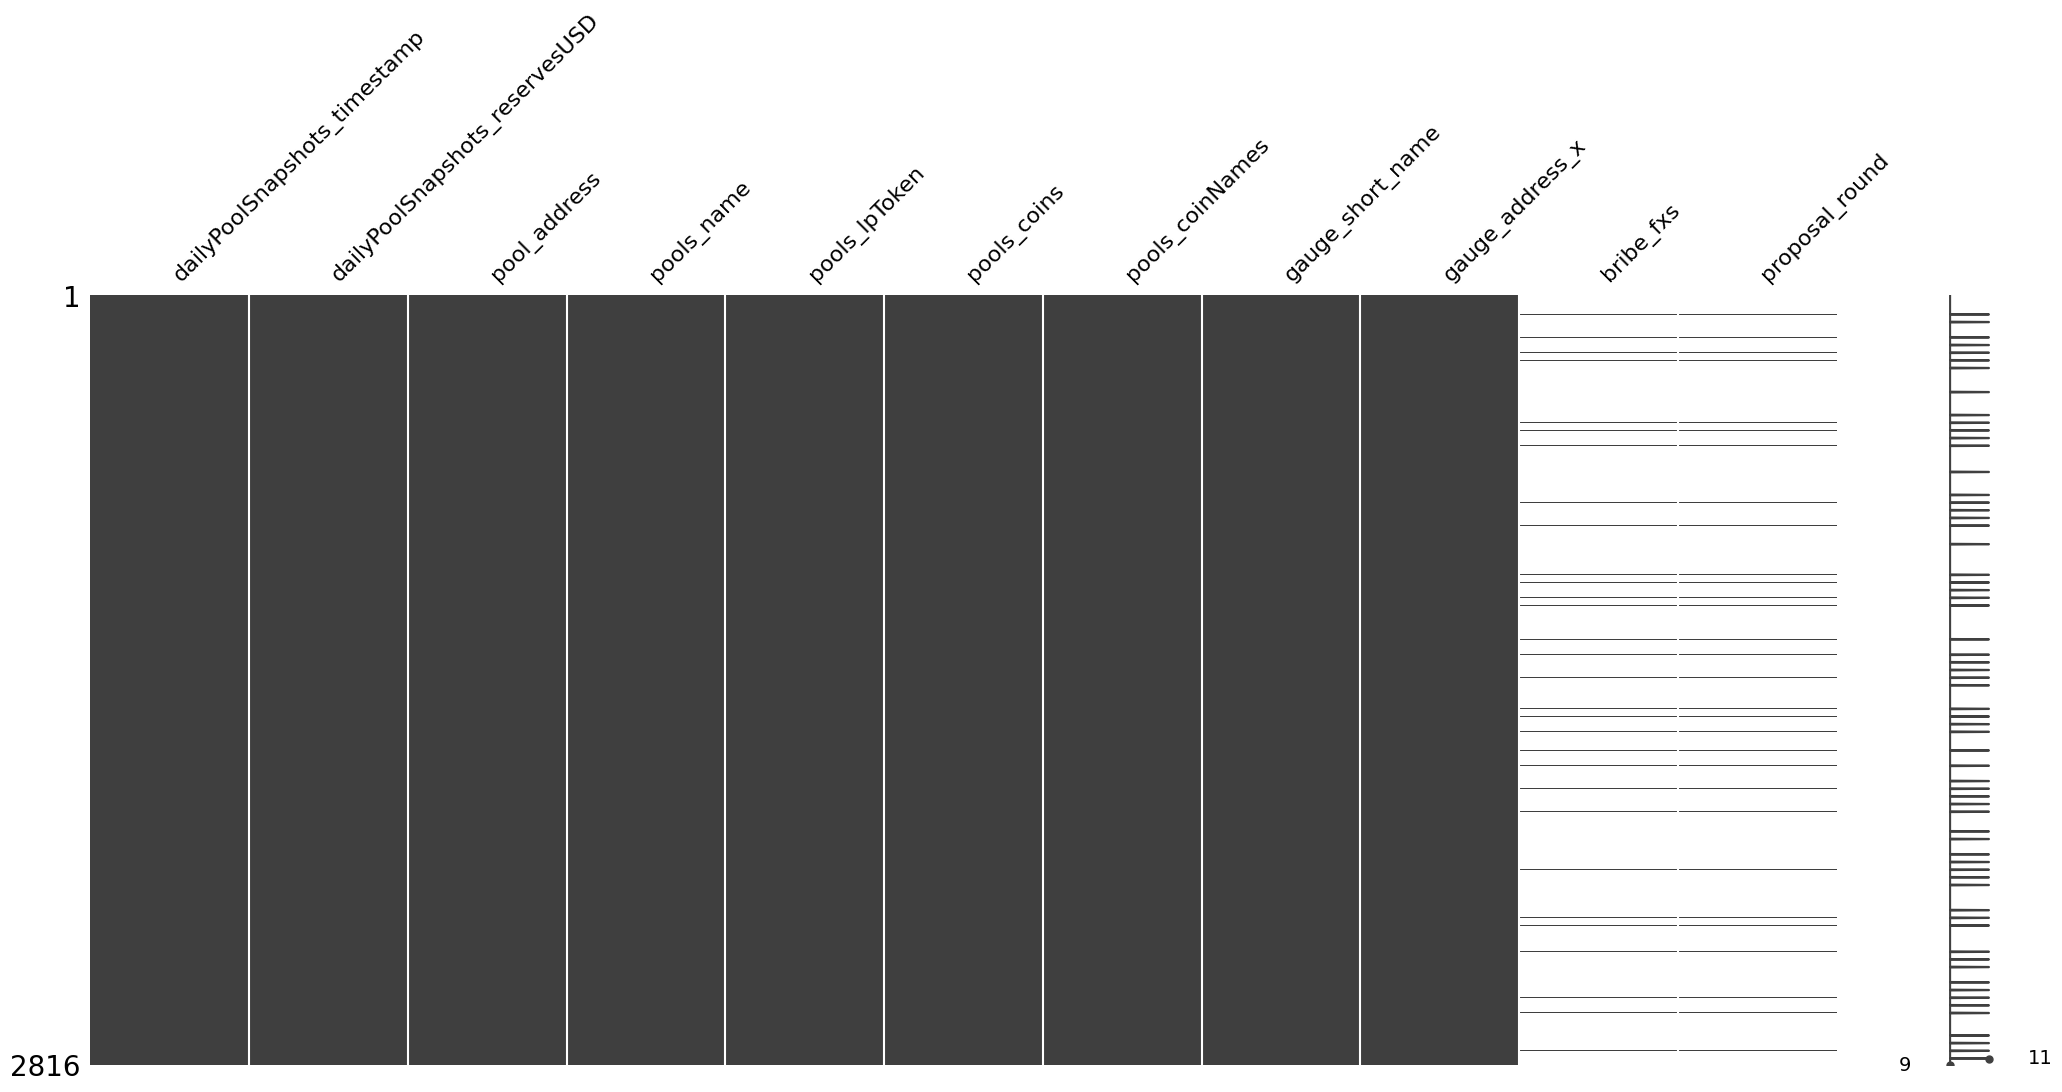

In [689]:
miss.matrix(dff)

In [690]:
dff.head()

dailyPoolSnapshots_timestamp  dailyPoolSnapshots_reservesUSD  \
0                   2022-06-30                        0.000000   
1                   2022-06-30                        0.000000   
2                   2022-07-01                        0.000000   
3                   2022-07-01                        0.000000   
4                   2022-07-02                    66782.220309   

                                 pool_address  \
0  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
1  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
2  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
3  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
4  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   

                                    pools_name  \
0  Curve.fi Factory USD Metapool: apeUSDFRAXBP   
1  Curve.fi Factory USD Metapool: apeUSDFRAXBP   
2  Curve.fi Factory USD Metapool: apeUSDFRAXBP   
3  Curve.fi Factory USD Metapool: apeUSDFRAXBP   
4  Curve.fi Factory USD Metapool: apeUSDFRAXBP   

                                pools_lpToken  \
0  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
1  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
2  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
3  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
4  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   

                                  pools_coins pools_coinNames  \
0  0xff709449528b6fb6b88f557f7d93dece33bca78d          ApeUSD   
1  0x3175df0976dfa876431c2e9ee6bc45b65d3473cc         crvFRAX   
2  0xff709449528b6fb6b88f557f7d93dece33bca78d          ApeUSD   
3  0x3175df0976dfa876431c2e9ee6bc45b65d3473cc         crvFRAX   
4  0xff709449528b6fb6b88f557f7d93dece33bca78d          ApeUSD   

          gauge_short_name                             gauge_address_x  \
0  apeusd+fraxbp (0x04b7…)  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
1  apeusd+fraxbp (0x04b7…)  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
2  apeusd+fraxbp (0x04b7…)  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
3  apeusd+fraxbp (0x04b7…)  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
4  apeusd+fraxbp (0x04b7…)  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   

  bribe_fxs  proposal_round  
0       NaN             NaN  
1       NaN             NaN  
2       NaN             NaN  
3       NaN             NaN  
4       NaN             NaN

In [717]:
max_bribe

11523.84

In [718]:
ncols = 3 
rows = []
row = []
gnames = dff.gauge_short_name.unique().tolist()

max_tvl = (
    dff.groupby(['dailyPoolSnapshots_timestamp', 'gauge_short_name'])['dailyPoolSnapshots_reservesUSD'].sum().max()
)
max_bribe = (
    dff['bribe_fxs'].max() 
)

while gnames: 
    gname = gnames.pop()
    # add data for this gauge to current row 
    sdf = dff.loc[dff.gauge_short_name == gname] 
    base = (
        alt.Chart(sdf)
        .transform_calculate(stack_order="datum.pools_coinNames === 'crvFRAX' ? 0 : 1")
        .encode(
            x="dailyPoolSnapshots_timestamp:T", 
            color=alt.Color("pools_coinNames:N", scale=alt.Scale(scheme="tableau20")), 
            order="stack_order:O", 
        )
        .properties(width=250, height=150) 
    )
    liquidity = base.mark_area().encode(
        y=alt.Y("dailyPoolSnapshots_reservesUSD:Q", scale=alt.Scale(domain=[0, max_tvl * 1.05])),
        tooltip=alt.Tooltip("dailyPoolSnapshots_reservesUSD:Q", format='$,d'), 
    )
    bribes = (
        base
        .transform_filter("datum.pools_coinNames === 'crvFRAX'")
        .mark_bar()
        .encode(
            y=alt.Y("bribe_fxs:Q", scale=alt.Scale(domain=[0, max_bribe * 1.05])),
            tooltip=alt.Tooltip("bribe_fxs:Q", format=',d'), 
        )
    )
    row.append(alt.vconcat(liquidity, bribes).resolve_scale(x="shared").resolve_axis(x='shared'))
    if len(row) == ncols: 
        rows.append(row) 
        row = []
    
rows = [alt.hconcat(*row) for row in rows]
chart = alt.vconcat(*rows)    
chart


/opt/miniconda3/envs/frax-bribes/lib/python3.10/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.VConcatChart(...)

In [701]:
sdf[~sdf.bribe_fxs.isna()].head()

# miss.matrix(sdf)
# ddf(df_liquidity.loc[df_liquidity.pools_coinNames == 'ApeUSD'].head(20))

dailyPoolSnapshots_timestamp  dailyPoolSnapshots_reservesUSD  \
70                    2022-08-04                    5.883776e+05   
71                    2022-08-04                    1.615037e+06   
98                    2022-08-18                    2.396964e+06   
99                    2022-08-18                    3.748778e+06   
154                   2022-09-15                    7.773186e+06   

                                   pool_address  \
70   0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
71   0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
98   0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
99   0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
154  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   

                                      pools_name  \
70   Curve.fi Factory USD Metapool: apeUSDFRAXBP   
71   Curve.fi Factory USD Metapool: apeUSDFRAXBP   
98   Curve.fi Factory USD Metapool: apeUSDFRAXBP   
99   Curve.fi Factory USD Metapool: apeUSDFRAXBP   
154  Curve.fi Factory USD Metapool: apeUSDFRAXBP   

                                  pools_lpToken  \
70   0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
71   0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
98   0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
99   0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
154  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   

                                    pools_coins pools_coinNames  \
70   0xff709449528b6fb6b88f557f7d93dece33bca78d          ApeUSD   
71   0x3175df0976dfa876431c2e9ee6bc45b65d3473cc         crvFRAX   
98   0xff709449528b6fb6b88f557f7d93dece33bca78d          ApeUSD   
99   0x3175df0976dfa876431c2e9ee6bc45b65d3473cc         crvFRAX   
154  0xff709449528b6fb6b88f557f7d93dece33bca78d          ApeUSD   

            gauge_short_name                             gauge_address_x  \
70   apeusd+fraxbp (0x04b7…)  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
71   apeusd+fraxbp (0x04b7…)  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
98   apeusd+fraxbp (0x04b7…)  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
99   apeusd+fraxbp (0x04b7…)  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   
154  apeusd+fraxbp (0x04b7…)  0x04b727c7e246ca70d496ecf52e6b6280f3c8077d   

    bribe_fxs  proposal_round  
70     1344.0            24.0  
71     1344.0            24.0  
98    1584.96            25.0  
99    1584.96            25.0  
154    2304.0            27.0